<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl


from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io

WEIGHTSANDBIASES = True
DOWNLOAD = False
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'

# from google.colab import drive
# drive.mount('/content/drive')

if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: /content/sample_data/ham

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pjvivesmorey (pjvivesmorey-uib) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [2]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [3]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [4]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [5]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  print(train_data.__getdist__())
  print(train_data.len)

  return train_data, test_data,validation_data


In [6]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data.__getitem__(i)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)

    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [7]:
def get_weights(increment = 2.0):

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  print(valors)
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1



  weights[1] *= increment
  weights[3] *= increment
  weights[4] *= increment


  weights = weights / weights.sum()


  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]),weights

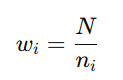

[0.00657042, **0.03958192**, 0.04008614, **0.08570948**, **0.13472377**, 0.31024417,
 0.3830841 ]

 provarem a augmentar en 1.5 els pesos de les enfermetats perilloses:

[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052,
 0.33901021]

 i en 2.0:

 [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257,
 0.30403135]

 Això pujarà el pes conjunt de les classes perilloses fins a 41%

In [8]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [9]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
    resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 3:
    googlenet = models.googlenet(weights="IMAGENET1K_V1")
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 4:
    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn




In [10]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [11]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [12]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [13]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)
  architecrures_inv = {0: 'alexnet',1:'vgg',2:'resnet'}


  patiente = 15
  best_recall = 0

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

        # torch.save(model, "my_model.pt")
        # wandb.log_model("./my_model.pt", architecrures_inv[MODEL], aliases=[f"epoch-{epoch+1}"])

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if train_recall > best_recall:
        patiente = 15
        best_recall = train_recall
      else:
        patiente -= 1

      if patiente == 0:
        torch.save(model.state_dict(), 'best_model.pt')
        print("Early Stopping!!")
        break


  wandb.finish()

In [14]:
def test(model,dataloader,weights_dir,loss_fn,device):
  model.load_state_dict(torch.load(weights_dir))
  test_acc,test_f1,test_recall,test_precision,test_loss  = validate(model,loss_fn,dataloader,device)

  if WEIGHTSANDBIASES:
    test_metrics = {"test/test_loss": test_loss/len(dataloader),
                      "test/test_acc":test_acc/len(dataloader),
                      "test/test_f1":test_f1/len(dataloader),
                      "test/test_recall": test_recall/len(dataloader),
                      "test/test_precision": test_precision/len(dataloader)}

    wandb.log({**test_metrics})

In [15]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet': 1,'resnet152':2,'googlenet':3,'alexnetmulticlass':4}
MODEL = architectures['alexnetmulticlass']

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    #transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    #transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

#load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)

#Realitzar el tuning de hiperparàmetres aquí


EPOCHS = 100
batch_size = 32

#[0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841 ]
# WEIGHTS = [[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021],
#  [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]]

#WEIGHTS = [2.33,1.5]

#get_weights()
increment = 1.0
binary_weights, multiple_weights = get_weights(increment)
WEIGHTS = [multiple_weights]
learning_rate  = 1e-5

for weights in product(WEIGHTS):

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

  model,loss_fn = tria_model(MODEL,weights)


  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  model.to(device)

  projectes = ['Ham10000-AlexnetBinary','Ham1000-ResnetBinary','Ham1000-Resnet152Binary','Ham10000-GoogleNetBinary','Ham10000-AlexnetMulticlass']

  #print(f"{batch_size} , {weights} , {learning_rate}")
  if WEIGHTSANDBIASES:
      wandb.init(
              project=projectes[MODEL],
              config={
                  "epochs": EPOCHS,
                  "batch_size": batch_size,
                  "lr": learning_rate,
                  "trsize":len(train_loader),
                  "trdist":TRAINING,
                  "vsize":len(val_loader),
                  "vdist":VALIDATION,
                  "weights":weights,
                  })
      config = wandb.config
      print(config)

  execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
  test(model,test_loader,"/content/best_model.pt",loss_fn,device)

0    5363
1     891
2     879
3     411
4     261
5     114
6      92
Name: count, dtype: int64
8011
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 165MB/s]
<ipython-input-9-e3878be59099>:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'epochs': 100, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': [[0.0065704208816761995, 0.03958191555403316, 0.04008614377765142, 0.08570947862186559, 0.13472376761969088, 0.31024416909604874, 0.383084104449034]]}


  0%|          | 0/100 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 1.5620773553373328
Accuracy train epoch: 1  train_acc: 0.5355396595436436
F1 train epoch: 1  train_f1: 0.5861216766880905
Recall train epoch: 1  train_recall: 0.5355396595436436


Pèrdua validació epoch: 1  val_loss: 1.2560020796954632
Accuracy val epoch: 1  val_acc: 0.5763671875
F1 val epoch: 1  val_f1: 0.6320655398851229
Recall val epoch: 1  val_recall: 0.5763671875
Recall val epoch: 1  val_precision: 0.8019532267830466


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 1.126260746997666
Accuracy train epoch: 2  train_acc: 0.6158094893154654
F1 train epoch: 2  train_f1: 0.663011065295706
Recall train epoch: 2  train_recall: 0.6158094893154654


Pèrdua validació epoch: 2  val_loss: 1.0411931909620762
Accuracy val epoch: 2  val_acc: 0.68828125
F1 val epoch: 2  val_f1: 0.7212130873924975
Recall val epoch: 2  val_recall: 0.68828125
Recall val epoch: 2  val_precision: 0.8065833527918792


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.9895016028586612
Accuracy train epoch: 3  train_acc: 0.6404835204636001
F1 train epoch: 3  train_f1: 0.685623410571851
Recall train epoch: 3  train_recall: 0.6404835204636001


Pèrdua validació epoch: 3  val_loss: 0.9633387066423893
Accuracy val epoch: 3  val_acc: 0.6529296875
F1 val epoch: 3  val_f1: 0.6962797911949027
Recall val epoch: 3  val_recall: 0.6529296875
Recall val epoch: 3  val_precision: 0.8261541019886774


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.8794858777428053
Accuracy train epoch: 4  train_acc: 0.6635050706265846
F1 train epoch: 4  train_f1: 0.7052589027865264
Recall train epoch: 4  train_recall: 0.6635050706265846


Pèrdua validació epoch: 4  val_loss: 0.9218962136656046
Accuracy val epoch: 4  val_acc: 0.652734375
F1 val epoch: 4  val_f1: 0.7047086156884288
Recall val epoch: 4  val_recall: 0.652734375
Recall val epoch: 4  val_precision: 0.8231421407432435


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.8075403279042339
Accuracy train epoch: 5  train_acc: 0.6760797718218037
F1 train epoch: 5  train_f1: 0.7166775910498572
Recall train epoch: 5  train_recall: 0.6760797718218037


Pèrdua validació epoch: 5  val_loss: 0.8549451027065516
Accuracy val epoch: 5  val_acc: 0.693359375
F1 val epoch: 5  val_f1: 0.7356700814165397
Recall val epoch: 5  val_recall: 0.693359375
Recall val epoch: 5  val_precision: 0.825629041535748


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.7427500833671882
Accuracy train epoch: 6  train_acc: 0.6922537124230351
F1 train epoch: 6  train_f1: 0.7327802022243222
Recall train epoch: 6  train_recall: 0.6922537124230351


Pèrdua validació epoch: 6  val_loss: 0.9108362207189202
Accuracy val epoch: 6  val_acc: 0.713671875
F1 val epoch: 6  val_f1: 0.7521976839592852
Recall val epoch: 6  val_recall: 0.713671875
Recall val epoch: 6  val_precision: 0.83503431082727


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.7275734569328239
Accuracy train epoch: 7  train_acc: 0.7010933538572981
F1 train epoch: 7  train_f1: 0.7376865899031225
Recall train epoch: 7  train_recall: 0.7010933538572981


Pèrdua validació epoch: 7  val_loss: 0.9041414232924581
Accuracy val epoch: 7  val_acc: 0.656640625
F1 val epoch: 7  val_f1: 0.7097991810656751
Recall val epoch: 7  val_recall: 0.656640625
Recall val epoch: 7  val_precision: 0.8340319511217952


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.6776259809851172
Accuracy train epoch: 8  train_acc: 0.7128078594712061
F1 train epoch: 8  train_f1: 0.74675796716779
Recall train epoch: 8  train_recall: 0.7128078594712061


Pèrdua validació epoch: 8  val_loss: 0.9155346751213074
Accuracy val epoch: 8  val_acc: 0.737890625
F1 val epoch: 8  val_f1: 0.76476045514632
Recall val epoch: 8  val_recall: 0.737890625
Recall val epoch: 8  val_precision: 0.830404593813016


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.6457447099733162
Accuracy train epoch: 9  train_acc: 0.7296382651213328
F1 train epoch: 9  train_f1: 0.7634937182634755
Recall train epoch: 9  train_recall: 0.7296382651213328


Pèrdua validació epoch: 9  val_loss: 0.7982949428260326
Accuracy val epoch: 9  val_acc: 0.73125
F1 val epoch: 9  val_f1: 0.7642016116382278
Recall val epoch: 9  val_recall: 0.73125
Recall val epoch: 9  val_precision: 0.8418218231560629


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.593915492355586
Accuracy train epoch: 10  train_acc: 0.7356256791017748
F1 train epoch: 10  train_f1: 0.7666265232826729
Recall train epoch: 10  train_recall: 0.7356256791017748


Pèrdua validació epoch: 10  val_loss: 0.863075909204781
Accuracy val epoch: 10  val_acc: 0.6982421875
F1 val epoch: 10  val_f1: 0.7374277709503134
Recall val epoch: 10  val_recall: 0.6982421875
Recall val epoch: 10  val_precision: 0.8471327447851401


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.5872906616840704
Accuracy train epoch: 11  train_acc: 0.7385797718218037
F1 train epoch: 11  train_f1: 0.7710886926758994
Recall train epoch: 11  train_recall: 0.7385797718218037


Pèrdua validació epoch: 11  val_loss: 0.8415085608139634
Accuracy val epoch: 11  val_acc: 0.725390625
F1 val epoch: 11  val_f1: 0.757457160610251
Recall val epoch: 11  val_recall: 0.725390625
Recall val epoch: 11  val_precision: 0.8459091959759757


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.5370761819807182
Accuracy train epoch: 12  train_acc: 0.7521504889532777
F1 train epoch: 12  train_f1: 0.7816698984683701
Recall train epoch: 12  train_recall: 0.7521504889532777


Pèrdua validació epoch: 12  val_loss: 0.8389377393759787
Accuracy val epoch: 12  val_acc: 0.7447265625
F1 val epoch: 12  val_f1: 0.7742355302526276
Recall val epoch: 12  val_recall: 0.7447265625
Recall val epoch: 12  val_precision: 0.8577129268492434


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.5258224328675593
Accuracy train epoch: 13  train_acc: 0.7559874139804419
F1 train epoch: 13  train_f1: 0.7843881642975372
Recall train epoch: 13  train_recall: 0.7559874139804419


Pèrdua validació epoch: 13  val_loss: 0.8182108378969133
Accuracy val epoch: 13  val_acc: 0.7662109375
F1 val epoch: 13  val_f1: 0.7862273464774144
Recall val epoch: 13  val_recall: 0.7662109375
Recall val epoch: 13  val_precision: 0.8534161993494751


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.49262341019879297
Accuracy train epoch: 14  train_acc: 0.7713237957261861
F1 train epoch: 14  train_f1: 0.7978339504315061
Recall train epoch: 14  train_recall: 0.7713237957261861


Pèrdua validació epoch: 14  val_loss: 0.8367555220611393
Accuracy val epoch: 14  val_acc: 0.7564453125
F1 val epoch: 14  val_f1: 0.7818198459025754
Recall val epoch: 14  val_recall: 0.7564453125
Recall val epoch: 14  val_precision: 0.8553448124470371


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.4665127610602227
Accuracy train epoch: 15  train_acc: 0.7815329590727996
F1 train epoch: 15  train_f1: 0.8079870107816216
Recall train epoch: 15  train_recall: 0.7815329590727996


Pèrdua validació epoch: 15  val_loss: 0.9348965496756136
Accuracy val epoch: 15  val_acc: 0.7625
F1 val epoch: 15  val_f1: 0.7776531092735649
Recall val epoch: 15  val_recall: 0.7625
Recall val epoch: 15  val_precision: 0.8450154584319914


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.4520506511527704
Accuracy train epoch: 16  train_acc: 0.7835023542194857
F1 train epoch: 16  train_f1: 0.810316922441977
Recall train epoch: 16  train_recall: 0.7835023542194857


Pèrdua validació epoch: 16  val_loss: 0.7920501818880439
Accuracy val epoch: 16  val_acc: 0.7685546875
F1 val epoch: 16  val_f1: 0.7934499486303357
Recall val epoch: 16  val_recall: 0.7685546875
Recall val epoch: 16  val_precision: 0.8588156343509


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.44777086109991565
Accuracy train epoch: 17  train_acc: 0.7881202462875769
F1 train epoch: 17  train_f1: 0.8130286129669564
Recall train epoch: 17  train_recall: 0.7881202462875769


Pèrdua validació epoch: 17  val_loss: 0.819844604935497
Accuracy val epoch: 17  val_acc: 0.740625
F1 val epoch: 17  val_f1: 0.7708717095339472
Recall val epoch: 17  val_recall: 0.740625
Recall val epoch: 17  val_precision: 0.8601762717416376


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.44179806050907566
Accuracy train epoch: 18  train_acc: 0.7903499637812387
F1 train epoch: 18  train_f1: 0.8148738017802181
Recall train epoch: 18  train_recall: 0.7903499637812387


Pèrdua validació epoch: 18  val_loss: 0.8222507648169994
Accuracy val epoch: 18  val_acc: 0.7498046875
F1 val epoch: 18  val_f1: 0.7758109110932234
Recall val epoch: 18  val_recall: 0.7498046875
Recall val epoch: 18  val_precision: 0.8539934685481425


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.40961695462465286
Accuracy train epoch: 19  train_acc: 0.8029359833393698
F1 train epoch: 19  train_f1: 0.822565919272467
Recall train epoch: 19  train_recall: 0.8029359833393698


Pèrdua validació epoch: 19  val_loss: 0.9016359513625503
Accuracy val epoch: 19  val_acc: 0.7181640625
F1 val epoch: 19  val_f1: 0.7478366390611922
Recall val epoch: 19  val_recall: 0.7181640625
Recall val epoch: 19  val_precision: 0.8450366887933405


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.37560727744107225
Accuracy train epoch: 20  train_acc: 0.8069087287214777
F1 train epoch: 20  train_f1: 0.8282421020387971
Recall train epoch: 20  train_recall: 0.8069087287214777


Pèrdua validació epoch: 20  val_loss: 0.8710638144984841
Accuracy val epoch: 20  val_acc: 0.7373046875
F1 val epoch: 20  val_f1: 0.7682176015574599
Recall val epoch: 20  val_recall: 0.7373046875
Recall val epoch: 20  val_precision: 0.8469298978856367


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.36450592001002147
Accuracy train epoch: 21  train_acc: 0.8045545092357841
F1 train epoch: 21  train_f1: 0.8266575541682628
Recall train epoch: 21  train_recall: 0.8045545092357841


Pèrdua validació epoch: 21  val_loss: 0.8985031724441797
Accuracy val epoch: 21  val_acc: 0.76015625
F1 val epoch: 21  val_f1: 0.7819419641329042
Recall val epoch: 21  val_recall: 0.76015625
Recall val epoch: 21  val_precision: 0.8690565421927801


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.36118871778012274
Accuracy train epoch: 22  train_acc: 0.8132809670409271
F1 train epoch: 22  train_f1: 0.8344334006913591
Recall train epoch: 22  train_recall: 0.8132809670409271


Pèrdua validació epoch: 22  val_loss: 0.8906010654754937
Accuracy val epoch: 22  val_acc: 0.7611328125
F1 val epoch: 22  val_f1: 0.7828456130534072
Recall val epoch: 22  val_recall: 0.7611328125
Recall val epoch: 22  val_precision: 0.861147731935105


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.33392271823973296
Accuracy train epoch: 23  train_acc: 0.8239881383556682
F1 train epoch: 23  train_f1: 0.8437311820656495
Recall train epoch: 23  train_recall: 0.8239881383556682


Pèrdua validació epoch: 23  val_loss: 0.8689236673526466
Accuracy val epoch: 23  val_acc: 0.76796875
F1 val epoch: 23  val_f1: 0.7844813584388123
Recall val epoch: 23  val_recall: 0.76796875
Recall val epoch: 23  val_precision: 0.8484313138829211


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.3192026223171042
Accuracy train epoch: 24  train_acc: 0.8243390076059399
F1 train epoch: 24  train_f1: 0.8439163420438766
Recall train epoch: 24  train_recall: 0.8243390076059399


Pèrdua validació epoch: 24  val_loss: 0.8234791222494096
Accuracy val epoch: 24  val_acc: 0.7708984375
F1 val epoch: 24  val_f1: 0.7923182870072704
Recall val epoch: 24  val_recall: 0.7708984375
Recall val epoch: 24  val_precision: 0.849470915712503


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.32132825124786196
Accuracy train epoch: 25  train_acc: 0.8249615175660993
F1 train epoch: 25  train_f1: 0.8443598178330229
Recall train epoch: 25  train_recall: 0.8249615175660993


Pèrdua validació epoch: 25  val_loss: 0.8004731335677207
Accuracy val epoch: 25  val_acc: 0.7693359375
F1 val epoch: 25  val_f1: 0.79801758677986
Recall val epoch: 25  val_recall: 0.7693359375
Recall val epoch: 25  val_precision: 0.8664325997754163


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.3026654812622355
Accuracy train epoch: 26  train_acc: 0.8351933176385368
F1 train epoch: 26  train_f1: 0.8523716905326457
Recall train epoch: 26  train_recall: 0.8351933176385368


Pèrdua validació epoch: 26  val_loss: 0.8725612265989184
Accuracy val epoch: 26  val_acc: 0.7818359375
F1 val epoch: 26  val_f1: 0.8001580019440606
Recall val epoch: 26  val_recall: 0.7818359375
Recall val epoch: 26  val_precision: 0.8584714943495513


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.2968169345679986
Accuracy train epoch: 27  train_acc: 0.8394037486417965
F1 train epoch: 27  train_f1: 0.8557862554665355
Recall train epoch: 27  train_recall: 0.8394037486417965


Pèrdua validació epoch: 27  val_loss: 0.8282296415418386
Accuracy val epoch: 27  val_acc: 0.7810546875
F1 val epoch: 27  val_f1: 0.8018279957877484
Recall val epoch: 27  val_recall: 0.7810546875
Recall val epoch: 27  val_precision: 0.8631787898179792


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.2768044516711359
Accuracy train epoch: 28  train_acc: 0.8465116805505252
F1 train epoch: 28  train_f1: 0.8646704986235983
Recall train epoch: 28  train_recall: 0.8465116805505252


Pèrdua validació epoch: 28  val_loss: 0.8444998092018068
Accuracy val epoch: 28  val_acc: 0.775
F1 val epoch: 28  val_f1: 0.7936387419605404
Recall val epoch: 28  val_recall: 0.775
Recall val epoch: 28  val_precision: 0.8508052301356352


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.2759720998931216
Accuracy train epoch: 29  train_acc: 0.8466135458167331
F1 train epoch: 29  train_f1: 0.8626332242434496
Recall train epoch: 29  train_recall: 0.8466135458167331


Pèrdua validació epoch: 29  val_loss: 0.8512899344787002
Accuracy val epoch: 29  val_acc: 0.7900390625
F1 val epoch: 29  val_f1: 0.8043645116636973
Recall val epoch: 29  val_recall: 0.7900390625
Recall val epoch: 29  val_precision: 0.8664979047963882


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.26385607620871876
Accuracy train epoch: 30  train_acc: 0.8470096885186527
F1 train epoch: 30  train_f1: 0.8629607062690285
Recall train epoch: 30  train_recall: 0.8470096885186527


Pèrdua validació epoch: 30  val_loss: 0.7679702001623809
Accuracy val epoch: 30  val_acc: 0.7673828125
F1 val epoch: 30  val_f1: 0.7929090575354684
Recall val epoch: 30  val_recall: 0.7673828125
Recall val epoch: 30  val_precision: 0.8567900321756686


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.2572548608351276
Accuracy train epoch: 31  train_acc: 0.8482547084389713
F1 train epoch: 31  train_f1: 0.8647875008710946
Recall train epoch: 31  train_recall: 0.8482547084389713


Pèrdua validació epoch: 31  val_loss: 0.9027000479400158
Accuracy val epoch: 31  val_acc: 0.7947265625
F1 val epoch: 31  val_f1: 0.8097291875958887
Recall val epoch: 31  val_recall: 0.7947265625
Recall val epoch: 31  val_precision: 0.8619083828965032


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.24430957540454143
Accuracy train epoch: 32  train_acc: 0.8521142701919594
F1 train epoch: 32  train_f1: 0.8677331777173042
Recall train epoch: 32  train_recall: 0.8521142701919594


Pèrdua validació epoch: 32  val_loss: 0.7866980298422277
Accuracy val epoch: 32  val_acc: 0.7982421875
F1 val epoch: 32  val_f1: 0.8136088793212456
Recall val epoch: 32  val_recall: 0.7982421875
Recall val epoch: 32  val_precision: 0.8739982020332556


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.24440676273696452
Accuracy train epoch: 33  train_acc: 0.8589618797537124
F1 train epoch: 33  train_f1: 0.8739591480228535
Recall train epoch: 33  train_recall: 0.8589618797537124


Pèrdua validació epoch: 33  val_loss: 0.8978166808374226
Accuracy val epoch: 33  val_acc: 0.7771484375
F1 val epoch: 33  val_f1: 0.795846277740004
Recall val epoch: 33  val_recall: 0.7771484375
Recall val epoch: 33  val_precision: 0.8564034982993982


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.23120148687723624
Accuracy train epoch: 34  train_acc: 0.8611915972473742
F1 train epoch: 34  train_f1: 0.8740108189476066
Recall train epoch: 34  train_recall: 0.8611915972473742


Pèrdua validació epoch: 34  val_loss: 0.8766854559071362
Accuracy val epoch: 34  val_acc: 0.7947265625
F1 val epoch: 34  val_f1: 0.8105210322804264
Recall val epoch: 34  val_recall: 0.7947265625
Recall val epoch: 34  val_precision: 0.8711427783296288


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.2188333024630746
Accuracy train epoch: 35  train_acc: 0.8665904563563925
F1 train epoch: 35  train_f1: 0.8800456045346662
Recall train epoch: 35  train_recall: 0.8665904563563925


Pèrdua validació epoch: 35  val_loss: 0.8795082322321832
Accuracy val epoch: 35  val_acc: 0.78359375
F1 val epoch: 35  val_f1: 0.7965353438574977
Recall val epoch: 35  val_recall: 0.78359375
Recall val epoch: 35  val_precision: 0.8578715932239872


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.22708226188245523
Accuracy train epoch: 36  train_acc: 0.8634326331039478
F1 train epoch: 36  train_f1: 0.8793195381230772
Recall train epoch: 36  train_recall: 0.8634326331039478


Pèrdua validació epoch: 36  val_loss: 0.9445978000294417
Accuracy val epoch: 36  val_acc: 0.7986328125
F1 val epoch: 36  val_f1: 0.8167004068212145
Recall val epoch: 36  val_recall: 0.7986328125
Recall val epoch: 36  val_precision: 0.8757253997467209


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.21711286382964884
Accuracy train epoch: 37  train_acc: 0.8751358203549439
F1 train epoch: 37  train_f1: 0.8887597558963156
Recall train epoch: 37  train_recall: 0.8751358203549439


Pèrdua validació epoch: 37  val_loss: 0.8905397127382457
Accuracy val epoch: 37  val_acc: 0.7748046875
F1 val epoch: 37  val_f1: 0.7946146380084658
Recall val epoch: 37  val_recall: 0.7748046875
Recall val epoch: 37  val_precision: 0.8510993939557109


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.20562758439209355
Accuracy train epoch: 38  train_acc: 0.8717742665700833
F1 train epoch: 38  train_f1: 0.8847013863167356
Recall train epoch: 38  train_recall: 0.8717742665700833


Pèrdua validació epoch: 38  val_loss: 0.7799245296046138
Accuracy val epoch: 38  val_acc: 0.769140625
F1 val epoch: 38  val_f1: 0.7908049444668521
Recall val epoch: 38  val_recall: 0.769140625
Recall val epoch: 38  val_precision: 0.8492463042125399


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.2091810948983488
Accuracy train epoch: 39  train_acc: 0.8704160630206447
F1 train epoch: 39  train_f1: 0.8840251557732244
Recall train epoch: 39  train_recall: 0.8704160630206447


Pèrdua validació epoch: 39  val_loss: 0.8412818228825927
Accuracy val epoch: 39  val_acc: 0.7974609375
F1 val epoch: 39  val_f1: 0.812835932316593
Recall val epoch: 39  val_recall: 0.7974609375
Recall val epoch: 39  val_precision: 0.8764983961261849


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.19789689887626713
Accuracy train epoch: 40  train_acc: 0.8777616805505252
F1 train epoch: 40  train_f1: 0.8909394060569974
Recall train epoch: 40  train_recall: 0.8777616805505252


Pèrdua validació epoch: 40  val_loss: 0.8193862391635776
Accuracy val epoch: 40  val_acc: 0.76875
F1 val epoch: 40  val_f1: 0.7936698085646577
Recall val epoch: 40  val_recall: 0.76875
Recall val epoch: 40  val_precision: 0.8585177230874157


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.18868342467928786
Accuracy train epoch: 41  train_acc: 0.8815986055776892
F1 train epoch: 41  train_f1: 0.8940309339939334
Recall train epoch: 41  train_recall: 0.8815986055776892


Pèrdua validació epoch: 41  val_loss: 0.8433636804111302
Accuracy val epoch: 41  val_acc: 0.7953125
F1 val epoch: 41  val_f1: 0.8131609143097712
Recall val epoch: 41  val_recall: 0.7953125
Recall val epoch: 41  val_precision: 0.865057760921411


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.18741140327605593
Accuracy train epoch: 42  train_acc: 0.8853449837015573
F1 train epoch: 42  train_f1: 0.8975294815252036
Recall train epoch: 42  train_recall: 0.8853449837015573


Pèrdua validació epoch: 42  val_loss: 1.0890706656500697
Accuracy val epoch: 42  val_acc: 0.7783203125
F1 val epoch: 42  val_f1: 0.796914843762379
Recall val epoch: 42  val_recall: 0.7783203125
Recall val epoch: 42  val_precision: 0.8625158340910627


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.18675425654997033
Accuracy train epoch: 43  train_acc: 0.8872238319449475
F1 train epoch: 43  train_f1: 0.8988232223850225
Recall train epoch: 43  train_recall: 0.8872238319449475


Pèrdua validació epoch: 43  val_loss: 0.924653216265142
Accuracy val epoch: 43  val_acc: 0.7623046875
F1 val epoch: 43  val_f1: 0.7801401671850825
Recall val epoch: 43  val_recall: 0.7623046875
Recall val epoch: 43  val_precision: 0.8595578661151961


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.17379377879187524
Accuracy train epoch: 44  train_acc: 0.8913210793190873
F1 train epoch: 44  train_f1: 0.9027596394615819
Recall train epoch: 44  train_recall: 0.8913210793190873


Pèrdua validació epoch: 44  val_loss: 0.9640348479151726
Accuracy val epoch: 44  val_acc: 0.7921875
F1 val epoch: 44  val_f1: 0.8081678076724393
Recall val epoch: 44  val_recall: 0.7921875
Recall val epoch: 44  val_precision: 0.8585133196909769


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.16911407684410118
Accuracy train epoch: 45  train_acc: 0.8960521550162984
F1 train epoch: 45  train_f1: 0.9067023966026877
Recall train epoch: 45  train_recall: 0.8960521550162984


Pèrdua validació epoch: 45  val_loss: 0.8422866566106677
Accuracy val epoch: 45  val_acc: 0.787890625
F1 val epoch: 45  val_f1: 0.8075973191785337
Recall val epoch: 45  val_recall: 0.787890625
Recall val epoch: 45  val_precision: 0.8574050686991737


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.1567221809757421
Accuracy train epoch: 46  train_acc: 0.9010322346975733
F1 train epoch: 46  train_f1: 0.9105639377358378
Recall train epoch: 46  train_recall: 0.9010322346975733


Pèrdua validació epoch: 46  val_loss: 0.8754870090633631
Accuracy val epoch: 46  val_acc: 0.79453125
F1 val epoch: 46  val_f1: 0.8114973255780767
Recall val epoch: 46  val_recall: 0.79453125
Recall val epoch: 46  val_precision: 0.8691537413406746


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.150976094524877
Accuracy train epoch: 47  train_acc: 0.9002739043824701
F1 train epoch: 47  train_f1: 0.9100666456817026
Recall train epoch: 47  train_recall: 0.9002739043824701


Pèrdua validació epoch: 47  val_loss: 0.9326851200312376
Accuracy val epoch: 47  val_acc: 0.819140625
F1 val epoch: 47  val_f1: 0.8268642632347818
Recall val epoch: 47  val_recall: 0.819140625
Recall val epoch: 47  val_precision: 0.8679262686434223


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.14953586231338312
Accuracy train epoch: 48  train_acc: 0.9016547446577327
F1 train epoch: 48  train_f1: 0.9116176210713166
Recall train epoch: 48  train_recall: 0.9016547446577327


Pèrdua validació epoch: 48  val_loss: 1.056495867203921
Accuracy val epoch: 48  val_acc: 0.8146484375
F1 val epoch: 48  val_f1: 0.8237502837619085
Recall val epoch: 48  val_recall: 0.8146484375
Recall val epoch: 48  val_precision: 0.8692096302547276


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.1588428169117862
Accuracy train epoch: 49  train_acc: 0.9015302426657008
F1 train epoch: 49  train_f1: 0.9115021170364698
Recall train epoch: 49  train_recall: 0.9015302426657008


Pèrdua validació epoch: 49  val_loss: 0.9867326292442158
Accuracy val epoch: 49  val_acc: 0.81640625
F1 val epoch: 49  val_f1: 0.8239365313221038
Recall val epoch: 49  val_recall: 0.81640625
Recall val epoch: 49  val_precision: 0.8687787715818331


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.14574562111476147
Accuracy train epoch: 50  train_acc: 0.9076534770010866
F1 train epoch: 50  train_f1: 0.9170944979361619
Recall train epoch: 50  train_recall: 0.9076534770010866


Pèrdua validació epoch: 50  val_loss: 0.9387840357376263
Accuracy val epoch: 50  val_acc: 0.8142578125
F1 val epoch: 50  val_f1: 0.8262791648063763
Recall val epoch: 50  val_recall: 0.8142578125
Recall val epoch: 50  val_precision: 0.8709082265380061


Batches (Època 51): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 51  train_loss: 0.1492689207671173
Accuracy train epoch: 51  train_acc: 0.9070196486780152
F1 train epoch: 51  train_f1: 0.9158797610387773
Recall train epoch: 51  train_recall: 0.9070196486780152


Pèrdua validació epoch: 51  val_loss: 0.8928664163686335
Accuracy val epoch: 51  val_acc: 0.7859375
F1 val epoch: 51  val_f1: 0.8045001852201568
Recall val epoch: 51  val_recall: 0.7859375
Recall val epoch: 51  val_precision: 0.8654370846423068


Batches (Època 52): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 52  train_loss: 0.1477166858921013
Accuracy train epoch: 52  train_acc: 0.9023904382470119
F1 train epoch: 52  train_f1: 0.9110505593730729
Recall train epoch: 52  train_recall: 0.9023904382470119


Pèrdua validació epoch: 52  val_loss: 0.9096083368640393
Accuracy val epoch: 52  val_acc: 0.8056640625
F1 val epoch: 52  val_f1: 0.8191017739599964
Recall val epoch: 52  val_recall: 0.8056640625
Recall val epoch: 52  val_precision: 0.8676096884531016


Batches (Època 53): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 53  train_loss: 0.12914671939037056
Accuracy train epoch: 53  train_acc: 0.9139691235059761
F1 train epoch: 53  train_f1: 0.921947452095456
Recall train epoch: 53  train_recall: 0.9139691235059761


Pèrdua validació epoch: 53  val_loss: 0.9453662182204425
Accuracy val epoch: 53  val_acc: 0.80078125
F1 val epoch: 53  val_f1: 0.8152645007753984
Recall val epoch: 53  val_recall: 0.80078125
Recall val epoch: 53  val_precision: 0.8755417346150307


Batches (Època 54): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 54  train_loss: 0.12617585783642513
Accuracy train epoch: 54  train_acc: 0.9124750996015937
F1 train epoch: 54  train_f1: 0.921758640341771
Recall train epoch: 54  train_recall: 0.9124750996015937


Pèrdua validació epoch: 54  val_loss: 0.9155886629596353
Accuracy val epoch: 54  val_acc: 0.808203125
F1 val epoch: 54  val_f1: 0.8186027376345123
Recall val epoch: 54  val_recall: 0.808203125
Recall val epoch: 54  val_precision: 0.8700295571116161


Batches (Època 55): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 55  train_loss: 0.12906391425911648
Accuracy train epoch: 55  train_acc: 0.9104943860919956
F1 train epoch: 55  train_f1: 0.9199554966135329
Recall train epoch: 55  train_recall: 0.9104943860919956


Pèrdua validació epoch: 55  val_loss: 0.9480934403836727
Accuracy val epoch: 55  val_acc: 0.8171875
F1 val epoch: 55  val_f1: 0.8215815395807025
Recall val epoch: 55  val_recall: 0.8171875
Recall val epoch: 55  val_precision: 0.8634921632820517


Batches (Època 56): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 56  train_loss: 0.12617176777100658
Accuracy train epoch: 56  train_acc: 0.9157234697573343
F1 train epoch: 56  train_f1: 0.9242010736718641
Recall train epoch: 56  train_recall: 0.9157234697573343


Pèrdua validació epoch: 56  val_loss: 1.1287180031649768
Accuracy val epoch: 56  val_acc: 0.8150390625
F1 val epoch: 56  val_f1: 0.821117598848413
Recall val epoch: 56  val_recall: 0.8150390625
Recall val epoch: 56  val_precision: 0.8583779516934118


Batches (Època 57): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 57  train_loss: 0.12420961087517648
Accuracy train epoch: 57  train_acc: 0.9190737051792829
F1 train epoch: 57  train_f1: 0.9275478492626251
Recall train epoch: 57  train_recall: 0.9190737051792829


Pèrdua validació epoch: 57  val_loss: 0.9521130486391485
Accuracy val epoch: 57  val_acc: 0.81015625
F1 val epoch: 57  val_f1: 0.819906435030881
Recall val epoch: 57  val_recall: 0.81015625
Recall val epoch: 57  val_precision: 0.8708066866202802


Batches (Època 58): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 58  train_loss: 0.128957757199428
Accuracy train epoch: 58  train_acc: 0.921812749003984
F1 train epoch: 58  train_f1: 0.9290157333717708
Recall train epoch: 58  train_recall: 0.921812749003984


Pèrdua validació epoch: 58  val_loss: 1.038464603945613
Accuracy val epoch: 58  val_acc: 0.7810546875
F1 val epoch: 58  val_f1: 0.7979750769559876
Recall val epoch: 58  val_recall: 0.7810546875
Recall val epoch: 58  val_precision: 0.8688363214341746


Batches (Època 59): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 59  train_loss: 0.1299789921599496
Accuracy train epoch: 59  train_acc: 0.9168326693227091
F1 train epoch: 59  train_f1: 0.9250247477759802
Recall train epoch: 59  train_recall: 0.9168326693227091


Pèrdua validació epoch: 59  val_loss: 0.9399296380579472
Accuracy val epoch: 59  val_acc: 0.79453125
F1 val epoch: 59  val_f1: 0.8059380886612829
Recall val epoch: 59  val_recall: 0.79453125
Recall val epoch: 59  val_precision: 0.8527975252694531


Batches (Època 60): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 60  train_loss: 0.11397365460253925
Accuracy train epoch: 60  train_acc: 0.9224352589641435
F1 train epoch: 60  train_f1: 0.9295751059768141
Recall train epoch: 60  train_recall: 0.9224352589641435


Pèrdua validació epoch: 60  val_loss: 1.0885290959849954
Accuracy val epoch: 60  val_acc: 0.792578125
F1 val epoch: 60  val_f1: 0.8020883358193701
Recall val epoch: 60  val_recall: 0.792578125
Recall val epoch: 60  val_precision: 0.8517049004666046


Batches (Època 61): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 61  train_loss: 0.10981062837167684
Accuracy train epoch: 61  train_acc: 0.9266796450561391
F1 train epoch: 61  train_f1: 0.9334480483733025
Recall train epoch: 61  train_recall: 0.9266796450561391


Pèrdua validació epoch: 61  val_loss: 1.202663955744356
Accuracy val epoch: 61  val_acc: 0.81875
F1 val epoch: 61  val_f1: 0.8235801928590217
Recall val epoch: 61  val_recall: 0.81875
Recall val epoch: 61  val_precision: 0.8660286190495979


Batches (Època 62): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 62  train_loss: 0.11334236062677258
Accuracy train epoch: 62  train_acc: 0.9245517928286853
F1 train epoch: 62  train_f1: 0.9317102117047019
Recall train epoch: 62  train_recall: 0.9245517928286853


Pèrdua validació epoch: 62  val_loss: 0.9181300806812942
Accuracy val epoch: 62  val_acc: 0.8208984375
F1 val epoch: 62  val_f1: 0.8281274407694759
Recall val epoch: 62  val_recall: 0.8208984375
Recall val epoch: 62  val_precision: 0.8669125018063277


Batches (Època 63): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 63  train_loss: 0.1150175494947044
Accuracy train epoch: 63  train_acc: 0.9256836291198841
F1 train epoch: 63  train_f1: 0.9326112868659879
Recall train epoch: 63  train_recall: 0.9256836291198841


Pèrdua validació epoch: 63  val_loss: 1.0659547916147858
Accuracy val epoch: 63  val_acc: 0.8146484375
F1 val epoch: 63  val_f1: 0.8237457256651028
Recall val epoch: 63  val_recall: 0.8146484375
Recall val epoch: 63  val_precision: 0.8678790966239359


Batches (Època 64): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 64  train_loss: 0.10094002389582801
Accuracy train epoch: 64  train_acc: 0.9300298804780877
F1 train epoch: 64  train_f1: 0.9365789292277549
Recall train epoch: 64  train_recall: 0.9300298804780877


Pèrdua validació epoch: 64  val_loss: 1.1981852995231748
Accuracy val epoch: 64  val_acc: 0.8048828125
F1 val epoch: 64  val_f1: 0.813940248440881
Recall val epoch: 64  val_recall: 0.8048828125
Recall val epoch: 64  val_precision: 0.8552207707375387


Batches (Època 65): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 65  train_loss: 0.09861406646260762
Accuracy train epoch: 65  train_acc: 0.931659724737414
F1 train epoch: 65  train_f1: 0.9382860974842755
Recall train epoch: 65  train_recall: 0.931659724737414


Pèrdua validació epoch: 65  val_loss: 1.142672862391919
Accuracy val epoch: 65  val_acc: 0.82109375
F1 val epoch: 65  val_f1: 0.8261409209795121
Recall val epoch: 65  val_recall: 0.82109375
Recall val epoch: 65  val_precision: 0.8724606929976124


Batches (Època 66): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 66  train_loss: 0.09089553776935515
Accuracy train epoch: 66  train_acc: 0.9348967765302426
F1 train epoch: 66  train_f1: 0.9417022560546424
Recall train epoch: 66  train_recall: 0.9348967765302426


Pèrdua validació epoch: 66  val_loss: 1.1012239269912243
Accuracy val epoch: 66  val_acc: 0.7982421875
F1 val epoch: 66  val_f1: 0.809661054507597
Recall val epoch: 66  val_recall: 0.7982421875
Recall val epoch: 66  val_precision: 0.8558185081622108


Batches (Època 67): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 67  train_loss: 0.09327071669893673
Accuracy train epoch: 67  train_acc: 0.9357569721115537
F1 train epoch: 67  train_f1: 0.9415559940057117
Recall train epoch: 67  train_recall: 0.9357569721115537


Pèrdua validació epoch: 67  val_loss: 1.1179231414571404
Accuracy val epoch: 67  val_acc: 0.785546875
F1 val epoch: 67  val_f1: 0.8010045129663939
Recall val epoch: 67  val_recall: 0.785546875
Recall val epoch: 67  val_precision: 0.8589108090918209


Batches (Època 68): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 68  train_loss: 0.11246366991449994
Accuracy train epoch: 68  train_acc: 0.9297808764940239
F1 train epoch: 68  train_f1: 0.9368470449958187
Recall train epoch: 68  train_recall: 0.9297808764940239


Pèrdua validació epoch: 68  val_loss: 0.9295117205474526
Accuracy val epoch: 68  val_acc: 0.80546875
F1 val epoch: 68  val_f1: 0.815594486229998
Recall val epoch: 68  val_recall: 0.80546875
Recall val epoch: 68  val_precision: 0.860819342685503


Batches (Època 69): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 69  train_loss: 0.09810335179271391
Accuracy train epoch: 69  train_acc: 0.9345232705541471
F1 train epoch: 69  train_f1: 0.9406039792408547
Recall train epoch: 69  train_recall: 0.9345232705541471


Pèrdua validació epoch: 69  val_loss: 0.9987978590652347
Accuracy val epoch: 69  val_acc: 0.8169921875
F1 val epoch: 69  val_f1: 0.819804874781329
Recall val epoch: 69  val_recall: 0.8169921875
Recall val epoch: 69  val_precision: 0.8585730949138122


Batches (Època 70): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 70  train_loss: 0.09942518616933747
Accuracy train epoch: 70  train_acc: 0.9335159362549801
F1 train epoch: 70  train_f1: 0.9397221291482879
Recall train epoch: 70  train_recall: 0.9335159362549801


Pèrdua validació epoch: 70  val_loss: 1.1994818150997162
Accuracy val epoch: 70  val_acc: 0.7947265625
F1 val epoch: 70  val_f1: 0.8087184443760318
Recall val epoch: 70  val_recall: 0.7947265625
Recall val epoch: 70  val_precision: 0.8681423865750663


Batches (Època 71): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 71  train_loss: 0.11540907858110282
Accuracy train epoch: 71  train_acc: 0.9289206809127127
F1 train epoch: 71  train_f1: 0.9353620691962601
Recall train epoch: 71  train_recall: 0.9289206809127127


Pèrdua validació epoch: 71  val_loss: 0.8673028731718659
Accuracy val epoch: 71  val_acc: 0.8095703125
F1 val epoch: 71  val_f1: 0.8207318844529997
Recall val epoch: 71  val_recall: 0.8095703125
Recall val epoch: 71  val_precision: 0.8618292055081477


Batches (Època 72): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 72  train_loss: 0.08794066299539638
Accuracy train epoch: 72  train_acc: 0.938507334299167
F1 train epoch: 72  train_f1: 0.9443719877260541
Recall train epoch: 72  train_recall: 0.938507334299167


Pèrdua validació epoch: 72  val_loss: 1.064938454888761
Accuracy val epoch: 72  val_acc: 0.8107421875
F1 val epoch: 72  val_f1: 0.8166360556305182
Recall val epoch: 72  val_recall: 0.8107421875
Recall val epoch: 72  val_precision: 0.8579874385425376


Batches (Època 73): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 73  train_loss: 0.08800373058135351
Accuracy train epoch: 73  train_acc: 0.9399900398406374
F1 train epoch: 73  train_f1: 0.9458975215784944
Recall train epoch: 73  train_recall: 0.9399900398406374


Pèrdua validació epoch: 73  val_loss: 0.9627634841017425
Accuracy val epoch: 73  val_acc: 0.8171875
F1 val epoch: 73  val_f1: 0.827950237309565
Recall val epoch: 73  val_recall: 0.8171875
Recall val epoch: 73  val_precision: 0.8647220888416708


Batches (Època 74): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 74  train_loss: 0.08003578167334496
Accuracy train epoch: 74  train_acc: 0.9418575697211156
F1 train epoch: 74  train_f1: 0.946922759072808
Recall train epoch: 74  train_recall: 0.9418575697211156


Pèrdua validació epoch: 74  val_loss: 1.0221544639207423
Accuracy val epoch: 74  val_acc: 0.809375
F1 val epoch: 74  val_f1: 0.8250683113234959
Recall val epoch: 74  val_recall: 0.809375
Recall val epoch: 74  val_precision: 0.8759593642048837


Batches (Època 75): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 75  train_loss: 0.08148956155233768
Accuracy train epoch: 75  train_acc: 0.9426159000362188
F1 train epoch: 75  train_f1: 0.9480218400373237
Recall train epoch: 75  train_recall: 0.9426159000362188


Pèrdua validació epoch: 75  val_loss: 1.3994306463282555
Accuracy val epoch: 75  val_acc: 0.81875
F1 val epoch: 75  val_f1: 0.817752634899377
Recall val epoch: 75  val_recall: 0.81875
Recall val epoch: 75  val_precision: 0.8678140458998631


Batches (Època 76): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 76  train_loss: 0.07841302127766597
Accuracy train epoch: 76  train_acc: 0.9481053060485332
F1 train epoch: 76  train_f1: 0.9532798852584901
Recall train epoch: 76  train_recall: 0.9481053060485332


Pèrdua validació epoch: 76  val_loss: 1.1435726187191904
Accuracy val epoch: 76  val_acc: 0.82265625
F1 val epoch: 76  val_f1: 0.8295120146748365
Recall val epoch: 76  val_recall: 0.82265625
Recall val epoch: 76  val_precision: 0.8711803972500872


Batches (Època 77): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 77  train_loss: 0.09529593104192341
Accuracy train epoch: 77  train_acc: 0.9386205179282868
F1 train epoch: 77  train_f1: 0.9444955271545465
Recall train epoch: 77  train_recall: 0.9386205179282868


Pèrdua validació epoch: 77  val_loss: 0.9769047871814109
Accuracy val epoch: 77  val_acc: 0.8193359375
F1 val epoch: 77  val_f1: 0.8283327266866166
Recall val epoch: 77  val_recall: 0.8193359375
Recall val epoch: 77  val_precision: 0.8796731749979196


Batches (Època 78): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 78  train_loss: 0.07593312396564005
Accuracy train epoch: 78  train_acc: 0.9497011952191236
F1 train epoch: 78  train_f1: 0.9543920574928076
Recall train epoch: 78  train_recall: 0.9497011952191236


Pèrdua validació epoch: 78  val_loss: 1.236382542643696
Accuracy val epoch: 78  val_acc: 0.8201171875
F1 val epoch: 78  val_f1: 0.8247869384363297
Recall val epoch: 78  val_recall: 0.8201171875
Recall val epoch: 78  val_precision: 0.8677528650522005


Batches (Època 79): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 79  train_loss: 0.07656055871226576
Accuracy train epoch: 79  train_acc: 0.9437364179645056
F1 train epoch: 79  train_f1: 0.9485861090881473
Recall train epoch: 79  train_recall: 0.9437364179645056


Pèrdua validació epoch: 79  val_loss: 1.0068313241936266
Accuracy val epoch: 79  val_acc: 0.8275390625
F1 val epoch: 79  val_f1: 0.829591332099341
Recall val epoch: 79  val_recall: 0.8275390625
Recall val epoch: 79  val_precision: 0.8637116504199992


Batches (Època 80): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 80  train_loss: 0.0734664600804463
Accuracy train epoch: 80  train_acc: 0.9483316733067729
F1 train epoch: 80  train_f1: 0.9531372159324345
Recall train epoch: 80  train_recall: 0.9483316733067729


Pèrdua validació epoch: 80  val_loss: 1.1459655647631735
Accuracy val epoch: 80  val_acc: 0.8259765625
F1 val epoch: 80  val_f1: 0.8323664321013989
Recall val epoch: 80  val_recall: 0.8259765625
Recall val epoch: 80  val_precision: 0.8746954210607204


Batches (Època 81): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 81  train_loss: 0.0754728390690518
Accuracy train epoch: 81  train_acc: 0.9453549438609199
F1 train epoch: 81  train_f1: 0.9499687340843567
Recall train epoch: 81  train_recall: 0.9453549438609199


Pèrdua validació epoch: 81  val_loss: 1.1045932839624584
Accuracy val epoch: 81  val_acc: 0.8298828125
F1 val epoch: 81  val_f1: 0.84043054918108
Recall val epoch: 81  val_recall: 0.8298828125
Recall val epoch: 81  val_precision: 0.8765800516056876


Batches (Època 82): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 82  train_loss: 0.07780932313280246
Accuracy train epoch: 82  train_acc: 0.9469847881202462
F1 train epoch: 82  train_f1: 0.9521407521310264
Recall train epoch: 82  train_recall: 0.9469847881202462


Pèrdua validació epoch: 82  val_loss: 1.0247222492471337
Accuracy val epoch: 82  val_acc: 0.8060546875
F1 val epoch: 82  val_f1: 0.817202153636911
Recall val epoch: 82  val_recall: 0.8060546875
Recall val epoch: 82  val_precision: 0.8696453683845676


Batches (Època 83): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 83  train_loss: 0.08870381801259292
Accuracy train epoch: 83  train_acc: 0.9434987323433538
F1 train epoch: 83  train_f1: 0.9493540113211445
Recall train epoch: 83  train_recall: 0.9434987323433538


Pèrdua validació epoch: 83  val_loss: 1.1832467407803051
Accuracy val epoch: 83  val_acc: 0.8205078125
F1 val epoch: 83  val_f1: 0.8203188066670322
Recall val epoch: 83  val_recall: 0.8205078125
Recall val epoch: 83  val_precision: 0.8549187349267101


Batches (Època 84): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 84  train_loss: 0.07541531165161976
Accuracy train epoch: 84  train_acc: 0.9497125135820355
F1 train epoch: 84  train_f1: 0.9539876783539415
Recall train epoch: 84  train_recall: 0.9497125135820355


Pèrdua validació epoch: 84  val_loss: 1.066519346088171
Accuracy val epoch: 84  val_acc: 0.8208984375
F1 val epoch: 84  val_f1: 0.8278943507066857
Recall val epoch: 84  val_recall: 0.8208984375
Recall val epoch: 84  val_precision: 0.8701339438373994


Batches (Època 85): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 85  train_loss: 0.0729212721223494
Accuracy train epoch: 85  train_acc: 0.9526892430278885
F1 train epoch: 85  train_f1: 0.9577460426340955
Recall train epoch: 85  train_recall: 0.9526892430278885


Pèrdua validació epoch: 85  val_loss: 1.0845179012976587
Accuracy val epoch: 85  val_acc: 0.8173828125
F1 val epoch: 85  val_f1: 0.8212891405557737
Recall val epoch: 85  val_recall: 0.8173828125
Recall val epoch: 85  val_precision: 0.8650329257761945


Batches (Època 86): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 86  train_loss: 0.06808972429573179
Accuracy train epoch: 86  train_acc: 0.9535607569721115
F1 train epoch: 86  train_f1: 0.9578813703368938
Recall train epoch: 86  train_recall: 0.9535607569721115


Pèrdua validació epoch: 86  val_loss: 1.2499581882730126
Accuracy val epoch: 86  val_acc: 0.834765625
F1 val epoch: 86  val_f1: 0.8368002983510436
Recall val epoch: 86  val_recall: 0.834765625
Recall val epoch: 86  val_precision: 0.8729256505186249


Batches (Època 87): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 87  train_loss: 0.06800810099079412
Accuracy train epoch: 87  train_acc: 0.9506972111553785
F1 train epoch: 87  train_f1: 0.9554878509621864
Recall train epoch: 87  train_recall: 0.9506972111553785


Pèrdua validació epoch: 87  val_loss: 1.185050482978113
Accuracy val epoch: 87  val_acc: 0.8298828125
F1 val epoch: 87  val_f1: 0.8334052755400104
Recall val epoch: 87  val_recall: 0.8298828125
Recall val epoch: 87  val_precision: 0.870785947594455


Batches (Època 88): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 88  train_loss: 0.08003085295473081
Accuracy train epoch: 88  train_acc: 0.9453662622238319
F1 train epoch: 88  train_f1: 0.9492966302558522
Recall train epoch: 88  train_recall: 0.9453662622238319


Pèrdua validació epoch: 88  val_loss: 1.3550755039323121
Accuracy val epoch: 88  val_acc: 0.8109375
F1 val epoch: 88  val_f1: 0.815454187160797
Recall val epoch: 88  val_recall: 0.8109375
Recall val epoch: 88  val_precision: 0.8673183069910779


Batches (Època 89): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 89  train_loss: 0.06153336864157739
Accuracy train epoch: 89  train_acc: 0.9555527888446215
F1 train epoch: 89  train_f1: 0.9591612161684929
Recall train epoch: 89  train_recall: 0.9555527888446215


Pèrdua validació epoch: 89  val_loss: 1.3359660120913759
Accuracy val epoch: 89  val_acc: 0.8177734375
F1 val epoch: 89  val_f1: 0.8223388593053389
Recall val epoch: 89  val_recall: 0.8177734375
Recall val epoch: 89  val_precision: 0.8646615998213415


Batches (Època 90): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 90  train_loss: 0.058779015454400584
Accuracy train epoch: 90  train_acc: 0.9588011590003622
F1 train epoch: 90  train_f1: 0.9618991300210522
Recall train epoch: 90  train_recall: 0.9588011590003622


Pèrdua validació epoch: 90  val_loss: 1.2551780566573143
Accuracy val epoch: 90  val_acc: 0.813671875
F1 val epoch: 90  val_f1: 0.8195338997704777
Recall val epoch: 90  val_recall: 0.813671875
Recall val epoch: 90  val_precision: 0.868738117265821


Batches (Època 91): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 91  train_loss: 0.06914364466577234
Accuracy train epoch: 91  train_acc: 0.954058764940239
F1 train epoch: 91  train_f1: 0.9578740776820058
Recall train epoch: 91  train_recall: 0.954058764940239


Pèrdua validació epoch: 91  val_loss: 1.2642990399617702
Accuracy val epoch: 91  val_acc: 0.8279296875
F1 val epoch: 91  val_f1: 0.836230813874801
Recall val epoch: 91  val_recall: 0.8279296875
Recall val epoch: 91  val_precision: 0.8859769960157189


Batches (Època 92): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 92  train_loss: 0.06658060359583047
Accuracy train epoch: 92  train_acc: 0.9532098877218399
F1 train epoch: 92  train_f1: 0.9571140618471062
Recall train epoch: 92  train_recall: 0.9532098877218399


Pèrdua validació epoch: 92  val_loss: 1.1723890011198819
Accuracy val epoch: 92  val_acc: 0.830859375
F1 val epoch: 92  val_f1: 0.836072731947106
Recall val epoch: 92  val_recall: 0.830859375
Recall val epoch: 92  val_precision: 0.8748521695699331


Batches (Època 93): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 93  train_loss: 0.05898892565953185
Accuracy train epoch: 93  train_acc: 0.9590388446215139
F1 train epoch: 93  train_f1: 0.9627383365483725
Recall train epoch: 93  train_recall: 0.9590388446215139


Pèrdua validació epoch: 93  val_loss: 1.2364957258105278
Accuracy val epoch: 93  val_acc: 0.82578125
F1 val epoch: 93  val_f1: 0.8328673128042845
Recall val epoch: 93  val_recall: 0.82578125
Recall val epoch: 93  val_precision: 0.8673961900261246


Batches (Època 94): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 94  train_loss: 0.06071036738302722
Accuracy train epoch: 94  train_acc: 0.9568091271278523
F1 train epoch: 94  train_f1: 0.9604747830527521
Recall train epoch: 94  train_recall: 0.9568091271278523


Pèrdua validació epoch: 94  val_loss: 1.2361489236354828
Accuracy val epoch: 94  val_acc: 0.818359375
F1 val epoch: 94  val_f1: 0.8238311773898419
Recall val epoch: 94  val_recall: 0.818359375
Recall val epoch: 94  val_precision: 0.8703392704360805


Batches (Època 95): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 95  train_loss: 0.05925009983398792
Accuracy train epoch: 95  train_acc: 0.9570468127490039
F1 train epoch: 95  train_f1: 0.9610490625861458
Recall train epoch: 95  train_recall: 0.9570468127490039


Pèrdua validació epoch: 95  val_loss: 1.2397750152740628
Accuracy val epoch: 95  val_acc: 0.8359375
F1 val epoch: 95  val_f1: 0.8366561626575436
Recall val epoch: 95  val_recall: 0.8359375
Recall val epoch: 95  val_precision: 0.8715304769055834


Batches (Època 96): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 96  train_loss: 0.06961790293147156
Accuracy train epoch: 96  train_acc: 0.9564243027888446
F1 train epoch: 96  train_f1: 0.9605493843926678
Recall train epoch: 96  train_recall: 0.9564243027888446


Pèrdua validació epoch: 96  val_loss: 1.414781522937119
Accuracy val epoch: 96  val_acc: 0.8291015625
F1 val epoch: 96  val_f1: 0.8299605313766018
Recall val epoch: 96  val_recall: 0.8291015625
Recall val epoch: 96  val_precision: 0.8768695399761867


Batches (Època 97): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 97  train_loss: 0.056389017052859425
Accuracy train epoch: 97  train_acc: 0.9567978087649402
F1 train epoch: 97  train_f1: 0.9608115411251038
Recall train epoch: 97  train_recall: 0.9567978087649402


Pèrdua validació epoch: 97  val_loss: 1.3028755869017914
Accuracy val epoch: 97  val_acc: 0.84375
F1 val epoch: 97  val_f1: 0.843131609231666
Recall val epoch: 97  val_recall: 0.84375
Recall val epoch: 97  val_precision: 0.8807874006430019


Batches (Època 98): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 98  train_loss: 0.05897958943642587
Accuracy train epoch: 98  train_acc: 0.9592878486055777
F1 train epoch: 98  train_f1: 0.9630092000487726
Recall train epoch: 98  train_recall: 0.9592878486055777


Pèrdua validació epoch: 98  val_loss: 1.234780534170568
Accuracy val epoch: 98  val_acc: 0.840625
F1 val epoch: 98  val_f1: 0.8411387068769407
Recall val epoch: 98  val_recall: 0.840625
Recall val epoch: 98  val_precision: 0.8816382254310071


Batches (Època 99): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 99  train_loss: 0.05295135403901665
Accuracy train epoch: 99  train_acc: 0.9631474103585658
F1 train epoch: 99  train_f1: 0.9664522265624352
Recall train epoch: 99  train_recall: 0.9631474103585658


Pèrdua validació epoch: 99  val_loss: 1.3831443791277707
Accuracy val epoch: 99  val_acc: 0.8158203125
F1 val epoch: 99  val_f1: 0.820508894217174
Recall val epoch: 99  val_recall: 0.8158203125
Recall val epoch: 99  val_precision: 0.8703116900917066


Batches (Època 100): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 100  train_loss: 0.07095231617563423
Accuracy train epoch: 100  train_acc: 0.9605328685258964
F1 train epoch: 100  train_f1: 0.9634319367352432
Recall train epoch: 100  train_recall: 0.9605328685258964


Pèrdua validació epoch: 100  val_loss: 1.1314588929526508
Accuracy val epoch: 100  val_acc: 0.82890625
F1 val epoch: 100  val_f1: 0.8358630271570212
Recall val epoch: 100  val_recall: 0.82890625
Recall val epoch: 100  val_precision: 0.8732250690344523


train/train_acc,▁▂▃▃▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train/train_f1,▁▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
train/train_loss,█▇▆▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████████
train/train_recall,▁▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█████████
val/val_acc,▂▁▃▁▃▅▅▄▄▅▅▆▆▆▅▆▆▇▆▅▆▇▇▇▆▆▇▇▇▆▇▇▇█▇█▇██▇
val/val_f1,▁▄▅▄▅▅▆▆▆▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████▇██
val/val_loss,▆▃▃▃▁▂▂▂▂▂▂▁▁▂▃▁▂▂▂▄▃▂▃▄▃▃▃▃▃▄▆▃▂▄▅▆▅▆█▆
val/val_precision,▂▂▁▃▃▃▅▄▇▄▅▆▄▆▅█▅▅█▄▆▅▅▇▇▆▇▅▇▅▇▇▆██▇▆█▇▇
val/val_recall,▁▃▄▅▃▆▆▆▅▆▇▆▇▇▆▇▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇██████
train/train_acc,0.96053


<ipython-input-14-9bf2008f8092>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_dir))


FileNotFoundError: [Errno 2] No such file or directory: '/content/best_model.pt'